In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from deep_convnet import DeepConvNet
%matplotlib inline

from common.functions import softmax
import cv2
import functools

Using TensorFlow backend.


In [2]:
def rotate_x(x, angle, scale=1.0):
    x = x.reshape(28,28)
    h, w = x.shape
    
    mat = cv2.getRotationMatrix2D((w/2, h/2), angle, scale)
    affine_x = cv2.warpAffine(x, mat, (w, h))

    return affine_x

In [3]:
def shift_x(x, shift):
    x = x.reshape(28,28)
    h, w = x.shape
    
    src = np.array([[0.0, 0.0],[0.0, 1.0],[1.0, 0.0]], np.float32)
    dest = src.copy()
    dest[:,0] += shift
    affine = cv2.getAffineTransform(src, dest)
    return cv2.warpAffine(x, affine, (w, h))

In [4]:
def shift_y(x, shift):
    x = x.reshape(28,28)
    h, w = x.shape
    
    src = np.array([[0.0, 0.0],[0.0, 1.0],[1.0, 0.0]], np.float32)
    dest = src.copy()
    dest[:,1] += shift
    affine = cv2.getAffineTransform(src, dest)
    return cv2.warpAffine(x, affine, (w, h))

In [5]:
(x_train, t_train), (x_test, t_test) = mnist.load_data()

In [6]:
eps = 0.3

In [7]:
x_test = x_test.reshape(-1,1,28,28).astype(np.float32) / 255.0

In [8]:
network = DeepConvNet()

network.load_params("deep_convnet_params.pkl")
print("loaded Network Parameters!")

loaded Network Parameters!


In [9]:
def generate_setsudo(x, label, network):
    x = x.reshape(1, 1, 28, 28)
    
    d, g = network.gradient_for_fgsm(x, np.array([label]))
    d = d.reshape(28, 28)
    p = np.sign(d)

    return p

In [10]:
def generate_adv(x, label, network, eps=0.3):
    x = x.reshape(1, 1, 28, 28)
    p = generate_setsudo(x,label,network)
    adv = (x + eps*p).clip(min=0, max=1)
    adv = adv.reshape(1, 1, 28, 28)
    
    return adv

In [11]:
def predict(x, network):
    x = x.reshape(1, 1, 28, 28)
    
    pre = network.predict(x)
    pre_label = np.argmax(pre)
    pre_score = round(max(softmax(pre[0])), 2)
    
    return pre_label, pre_score

In [12]:
def show_generate_adv(x, label, network, eps=0.3):
    
    fig = plt.figure(figsize=(20, 20))
    fig.subplots_adjust(wspace=0.4, hspace=0.1)
    
    x = x.reshape(1, 1, 28, 28)
    
    pre_label_x, pre_score_x = predict(x, network)
    
    ax = fig.add_subplot(1, 3, 1)
    ax.set_title(f"{pre_label_x} : {pre_score_x}")
    ax.imshow(x.reshape(28,28), 'gray')
    
    p = generate_setsudo(x, label, network)
    
    pre_label_p, pre_score_p = predict(p, network)
    
    ax = fig.add_subplot(1, 3, 2)
    ax.set_title(f"{pre_label_p} : {pre_score_p}")
    ax.imshow(p, 'gray')
    
    adv = (x + eps*p).clip(min=0, max=1)
    
    pre_label_adv, pre_score_adv = predict(adv, network)
    
    ax = fig.add_subplot(1, 3, 3)
    ax.set_title(f"{pre_label_adv} : {pre_score_adv}")
    ax.imshow(adv.reshape(28,28), 'gray')
    
    return adv

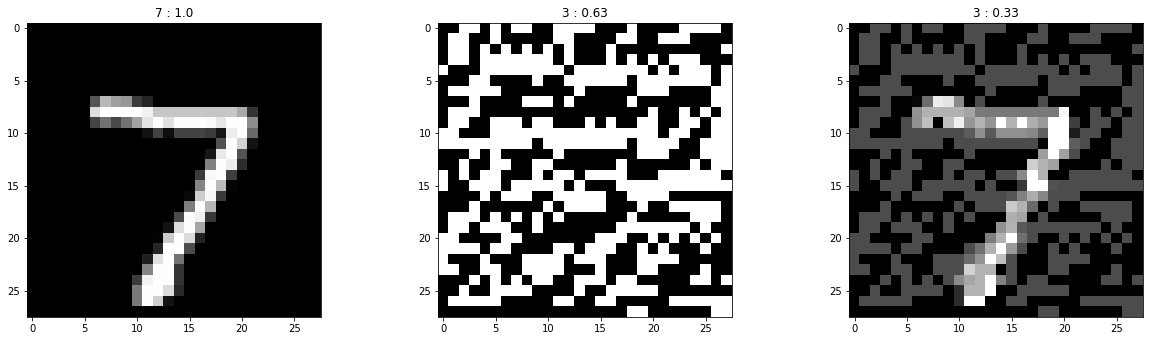

In [13]:
x = x_test[0]
t = t_test[0]
adv = show_generate_adv(x, t, network, eps)

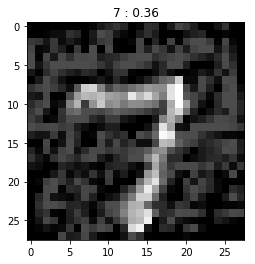

In [14]:
rotate_adv = rotate_x(adv, 10)
pre_label_adv, pre_score_adv = predict(rotate_adv, network)

plt.title(f"{pre_label_adv} : {pre_score_adv}")
plt.imshow(rotate_adv.reshape(28,28), 'gray')
plt.show()

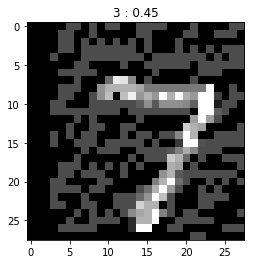

In [15]:
shift_x_adv = shift_x(adv, 3)
pre_label_adv, pre_score_adv = predict(shift_x_adv, network)

plt.title(f"{pre_label_adv} : {pre_score_adv}")
plt.imshow(shift_x_adv.reshape(28,28), 'gray')
plt.show()

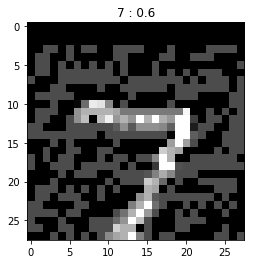

In [16]:
shift_y_adv = shift_y(adv, 3)
pre_label_adv, pre_score_adv = predict(shift_y_adv, network)

plt.title(f"{pre_label_adv} : {pre_score_adv}")
plt.imshow(shift_y_adv.reshape(28,28), 'gray')
plt.show()

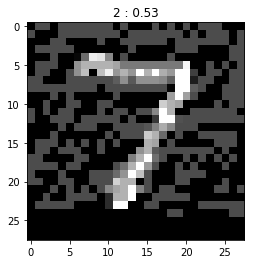

In [17]:
shift_y_adv = shift_y(adv, -3)
pre_label_adv, pre_score_adv = predict(shift_y_adv, network)

plt.title(f"{pre_label_adv} : {pre_score_adv}")
plt.imshow(shift_y_adv.reshape(28,28), 'gray')
plt.show()

In [18]:
def generate_adv_list(x_list, t_list, network, eps=0.3):
    x_list = x_list.reshape(-1,28,28)
    adv_list = []
    for x,t in zip(x_list, t_list):
        adv = generate_adv(x,t,network,eps)
        adv_list.append(adv.reshape(1,28,28))
        
    return np.array(adv_list)

In [19]:
adv_test = generate_adv_list(x_test[:1000], t_test[:1000],network,eps)
adv_test.shape

(1000, 1, 28, 28)

In [20]:
def rotate_x_pertial(angle, scale=1.0):
    return functools.partial(rotate_x,angle=angle, scale=scale)

def shift_x_pertial(shift):
    return functools.partial(shift_x,shift=shift)

def shift_y_pertial(shift):
    return functools.partial(shift_y,shift=shift)

In [21]:
def generate_affine_list(func, x_list):
    x_list = x_list.reshape(-1,28,28)
    affine_list = []
    for x in x_list:
        affine = func(x=x)
        affine_list.append(affine.reshape(1,28,28))
        
    return np.array(affine_list)

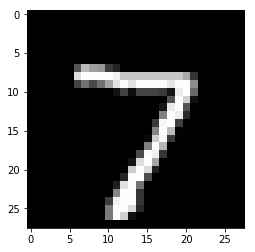

0.988

In [22]:
plt.imshow(x_test[0].reshape(28,28), 'gray')
plt.show()
x_acc = network.accuracy(x_test[:1000], t_test[:1000])
x_acc

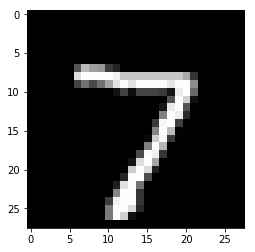

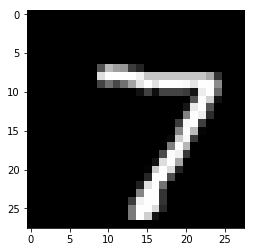

0.971

In [23]:
plt.imshow(x_test[0].reshape(28,28), 'gray')
plt.show()
affine_test = generate_affine_list(shift_x_pertial(3),x_test[:1000])
plt.imshow(affine_test[0].reshape(28,28), 'gray')
plt.show()
affine_acc = network.accuracy(affine_test[:1000], t_test[:1000])
affine_acc

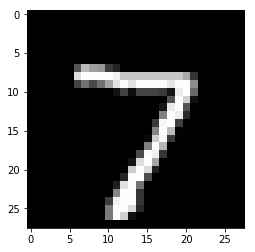

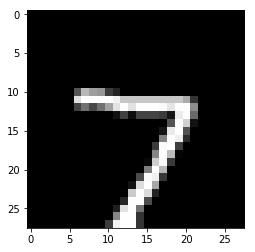

0.942

In [24]:
plt.imshow(x_test[0].reshape(28,28), 'gray')
plt.show()
affine_test = generate_affine_list(shift_y_pertial(3),x_test[:1000])
plt.imshow(affine_test[0].reshape(28,28), 'gray')
plt.show()
affine_acc = network.accuracy(affine_test[:1000], t_test[:1000])
affine_acc

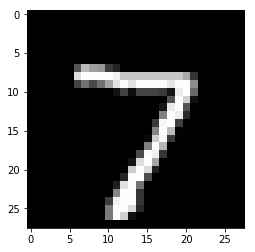

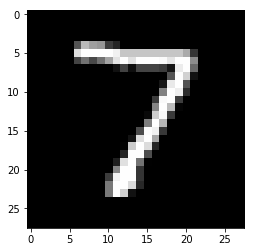

0.896

In [25]:
plt.imshow(x_test[0].reshape(28,28), 'gray')
plt.show()
affine_test = generate_affine_list(shift_y_pertial(-3),x_test[:1000])
plt.imshow(affine_test[0].reshape(28,28), 'gray')
plt.show()
affine_acc = network.accuracy(affine_test[:1000], t_test[:1000])
affine_acc

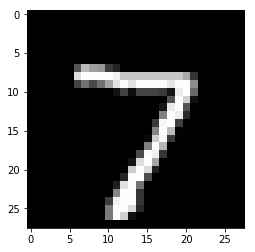

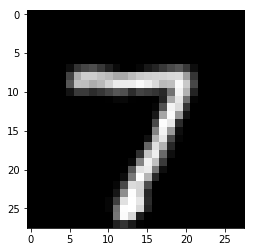

0.989

In [26]:
plt.imshow(x_test[0].reshape(28,28), 'gray')
plt.show()
affine_test = generate_affine_list(rotate_x_pertial(5),x_test[:1000])
plt.imshow(affine_test[0].reshape(28,28), 'gray')
plt.show()
affine_acc = network.accuracy(affine_test[:1000], t_test[:1000])
affine_acc

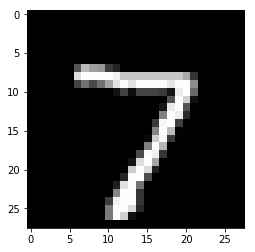

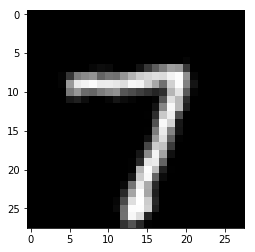

0.986

In [27]:
plt.imshow(x_test[0].reshape(28,28), 'gray')
plt.show()
affine_test = generate_affine_list(rotate_x_pertial(10),x_test[:1000])
plt.imshow(affine_test[0].reshape(28,28), 'gray')
plt.show()
affine_acc = network.accuracy(affine_test[:1000], t_test[:1000])
affine_acc

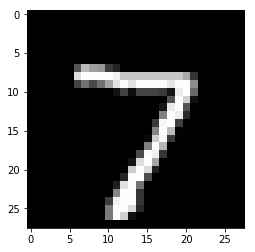

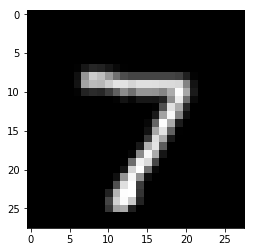

0.987

In [28]:
plt.imshow(x_test[0].reshape(28,28), 'gray')
plt.show()
affine_test = generate_affine_list(rotate_x_pertial(0, 0.9),x_test[:1000])
plt.imshow(affine_test[0].reshape(28,28), 'gray')
plt.show()
affine_acc = network.accuracy(affine_test[:1000], t_test[:1000])
affine_acc

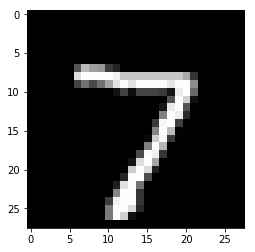

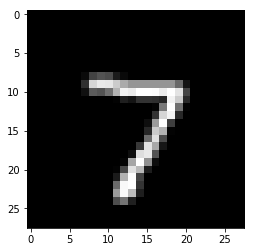

0.981

In [29]:
plt.imshow(x_test[0].reshape(28,28), 'gray')
plt.show()
affine_test = generate_affine_list(rotate_x_pertial(0, 0.8),x_test[:1000])
plt.imshow(affine_test[0].reshape(28,28), 'gray')
plt.show()
affine_acc = network.accuracy(affine_test[:1000], t_test[:1000])
affine_acc

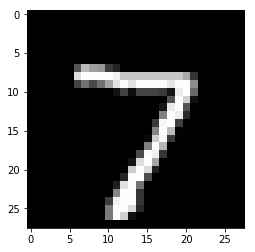

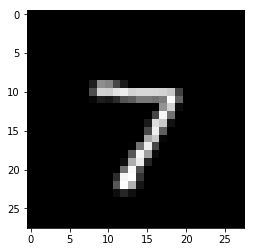

0.951

In [30]:
plt.imshow(x_test[0].reshape(28,28), 'gray')
plt.show()
affine_test = generate_affine_list(rotate_x_pertial(0, 0.7),x_test[:1000])
plt.imshow(affine_test[0].reshape(28,28), 'gray')
plt.show()
affine_acc = network.accuracy(affine_test[:1000], t_test[:1000])
affine_acc

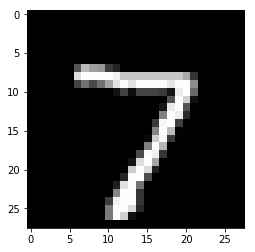

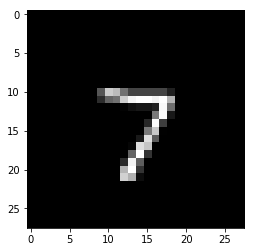

0.859

In [31]:
plt.imshow(x_test[0].reshape(28,28), 'gray')
plt.show()
affine_test = generate_affine_list(rotate_x_pertial(0, 0.6),x_test[:1000])
plt.imshow(affine_test[0].reshape(28,28), 'gray')
plt.show()
affine_acc = network.accuracy(affine_test[:1000], t_test[:1000])
affine_acc

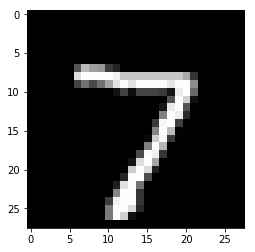

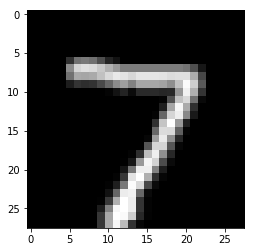

0.987

In [32]:
plt.imshow(x_test[0].reshape(28,28), 'gray')
plt.show()
affine_test = generate_affine_list(rotate_x_pertial(0, 1.1),x_test[:1000])
plt.imshow(affine_test[0].reshape(28,28), 'gray')
plt.show()
affine_acc = network.accuracy(affine_test[:1000], t_test[:1000])
affine_acc

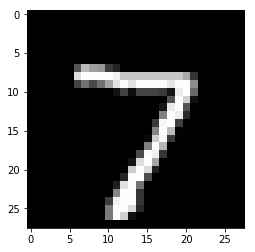

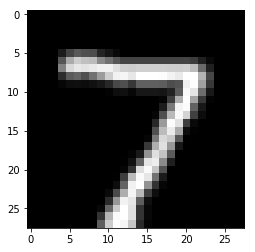

0.982

In [33]:
plt.imshow(x_test[0].reshape(28,28), 'gray')
plt.show()
affine_test = generate_affine_list(rotate_x_pertial(0, 1.2),x_test[:1000])
plt.imshow(affine_test[0].reshape(28,28), 'gray')
plt.show()
affine_acc = network.accuracy(affine_test[:1000], t_test[:1000])
affine_acc

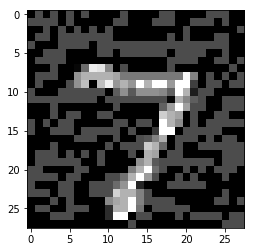

0.334

In [34]:
plt.imshow(adv_test[0].reshape(28,28), 'gray')
plt.show()
affine_acc = network.accuracy(adv_test[:1000], t_test[:1000])
affine_acc

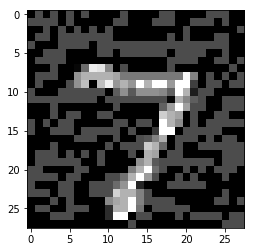

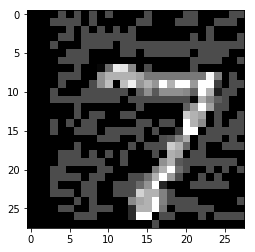

0.333

In [35]:
plt.imshow(adv_test[0].reshape(28,28), 'gray')
plt.show()
affine_test = generate_affine_list(shift_x_pertial(3),adv_test[:1000])
plt.imshow(affine_test[0].reshape(28,28), 'gray')
plt.show()
affine_acc = network.accuracy(affine_test[:1000], t_test[:1000])
affine_acc

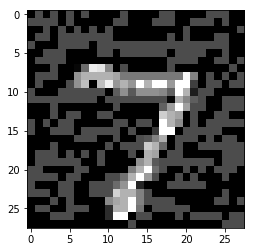

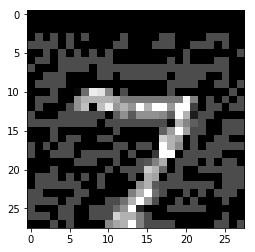

0.35

In [36]:
plt.imshow(adv_test[0].reshape(28,28), 'gray')
plt.show()
affine_test = generate_affine_list(shift_y_pertial(3),adv_test[:1000])
plt.imshow(affine_test[0].reshape(28,28), 'gray')
plt.show()
affine_acc = network.accuracy(affine_test[:1000], t_test[:1000])
affine_acc

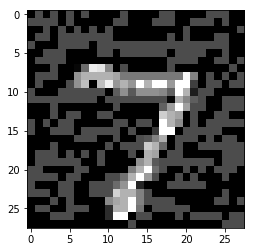

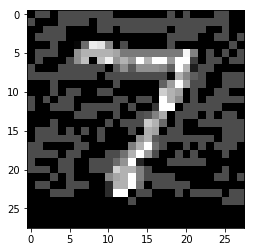

0.311

In [37]:
plt.imshow(adv_test[0].reshape(28,28), 'gray')
plt.show()
affine_test = generate_affine_list(shift_y_pertial(-3),adv_test[:1000])
plt.imshow(affine_test[0].reshape(28,28), 'gray')
plt.show()
affine_acc = network.accuracy(affine_test[:1000], t_test[:1000])
affine_acc

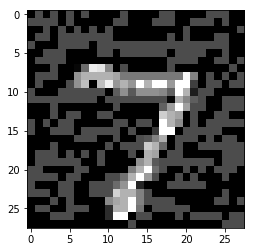

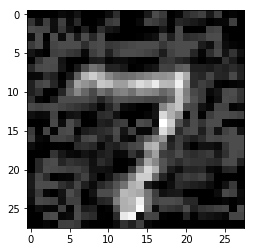

0.444

In [38]:
plt.imshow(adv_test[0].reshape(28,28), 'gray')
plt.show()
affine_test = generate_affine_list(rotate_x_pertial(5),adv_test[:1000])
plt.imshow(affine_test[0].reshape(28,28), 'gray')
plt.show()
affine_acc = network.accuracy(affine_test[:1000], t_test[:1000])
affine_acc

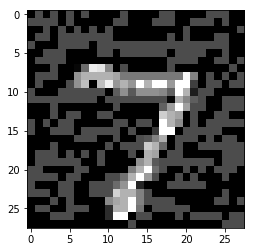

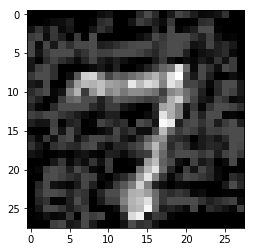

0.482

In [39]:
plt.imshow(adv_test[0].reshape(28,28), 'gray')
plt.show()
affine_test = generate_affine_list(rotate_x_pertial(10),adv_test[:1000])
plt.imshow(affine_test[0].reshape(28,28), 'gray')
plt.show()
affine_acc = network.accuracy(affine_test[:1000], t_test[:1000])
affine_acc

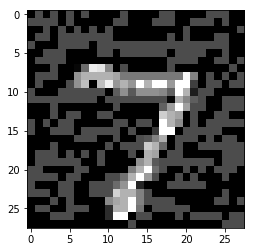

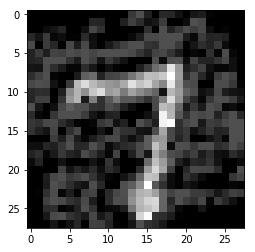

0.522

In [40]:
plt.imshow(adv_test[0].reshape(28,28), 'gray')
plt.show()
affine_test = generate_affine_list(rotate_x_pertial(15),adv_test[:1000])
plt.imshow(affine_test[0].reshape(28,28), 'gray')
plt.show()
affine_acc = network.accuracy(affine_test[:1000], t_test[:1000])
affine_acc

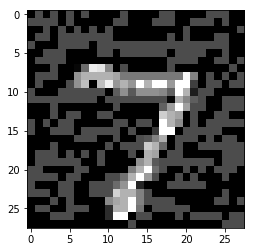

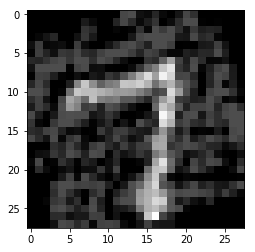

0.529

In [41]:
plt.imshow(adv_test[0].reshape(28,28), 'gray')
plt.show()
affine_test = generate_affine_list(rotate_x_pertial(20),adv_test[:1000])
plt.imshow(affine_test[0].reshape(28,28), 'gray')
plt.show()
affine_acc = network.accuracy(affine_test[:1000], t_test[:1000])
affine_acc

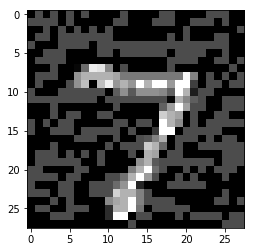

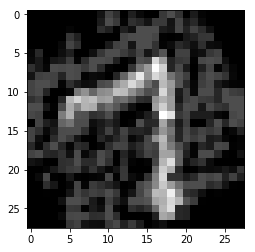

0.49

In [42]:
plt.imshow(adv_test[0].reshape(28,28), 'gray')
plt.show()
affine_test = generate_affine_list(rotate_x_pertial(30),adv_test[:1000])
plt.imshow(affine_test[0].reshape(28,28), 'gray')
plt.show()
affine_acc = network.accuracy(affine_test[:1000], t_test[:1000])
affine_acc

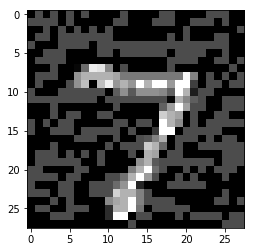

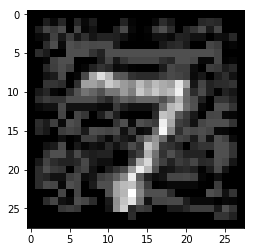

0.458

In [43]:
plt.imshow(adv_test[0].reshape(28,28), 'gray')
plt.show()
affine_test = generate_affine_list(rotate_x_pertial(0,0.9),adv_test[:1000])
plt.imshow(affine_test[0].reshape(28,28), 'gray')
plt.show()
affine_acc = network.accuracy(affine_test[:1000], t_test[:1000])
affine_acc

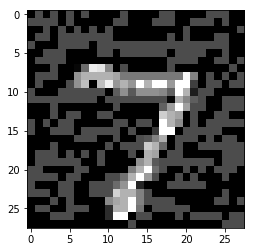

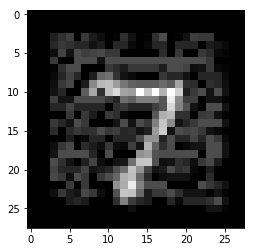

0.477

In [44]:
plt.imshow(adv_test[0].reshape(28,28), 'gray')
plt.show()
affine_test = generate_affine_list(rotate_x_pertial(0,0.8),adv_test[:1000])
plt.imshow(affine_test[0].reshape(28,28), 'gray')
plt.show()
affine_acc = network.accuracy(affine_test[:1000], t_test[:1000])
affine_acc

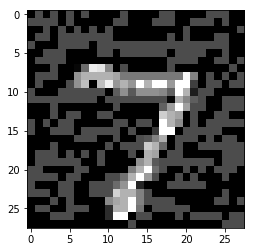

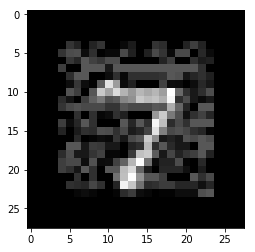

0.428

In [45]:
plt.imshow(adv_test[0].reshape(28,28), 'gray')
plt.show()
affine_test = generate_affine_list(rotate_x_pertial(0,0.7),adv_test[:1000])
plt.imshow(affine_test[0].reshape(28,28), 'gray')
plt.show()
affine_acc = network.accuracy(affine_test[:1000], t_test[:1000])
affine_acc

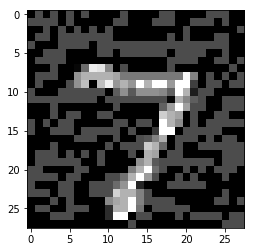

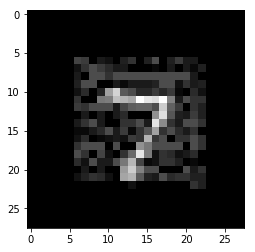

0.404

In [46]:
plt.imshow(adv_test[0].reshape(28,28), 'gray')
plt.show()
affine_test = generate_affine_list(rotate_x_pertial(0,0.6),adv_test[:1000])
plt.imshow(affine_test[0].reshape(28,28), 'gray')
plt.show()
affine_acc = network.accuracy(affine_test[:1000], t_test[:1000])
affine_acc

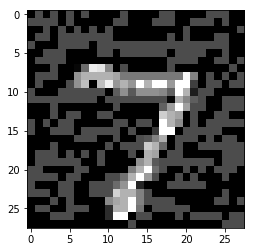

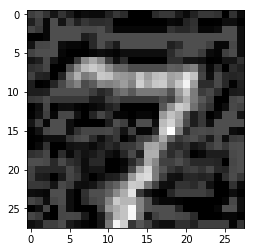

0.432

In [47]:
plt.imshow(adv_test[0].reshape(28,28), 'gray')
plt.show()
affine_test = generate_affine_list(rotate_x_pertial(0,1.1),adv_test[:1000])
plt.imshow(affine_test[0].reshape(28,28), 'gray')
plt.show()
affine_acc = network.accuracy(affine_test[:1000], t_test[:1000])
affine_acc

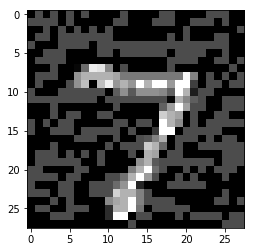

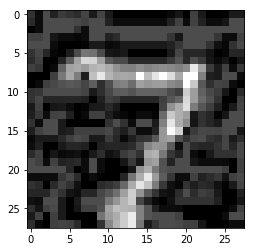

0.466

In [48]:
plt.imshow(adv_test[0].reshape(28,28), 'gray')
plt.show()
affine_test = generate_affine_list(rotate_x_pertial(0,1.2),adv_test[:1000])
plt.imshow(affine_test[0].reshape(28,28), 'gray')
plt.show()
affine_acc = network.accuracy(affine_test[:1000], t_test[:1000])
affine_acc

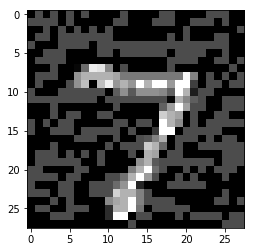

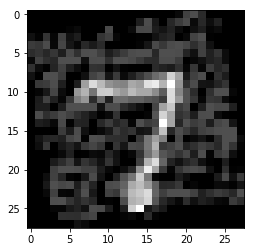

0.491

In [49]:
plt.imshow(adv_test[0].reshape(28,28), 'gray')
plt.show()
affine_test = generate_affine_list(rotate_x_pertial(10,0.9),adv_test[:1000])
plt.imshow(affine_test[0].reshape(28,28), 'gray')
plt.show()
affine_acc = network.accuracy(affine_test[:1000], t_test[:1000])
affine_acc